## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten
# Datenanalyse der Hauptstudie 2018: Inferenzstatisik

##### Werkzeuge und Daten importieren

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import math
from scipy import stats
from biofes import biplot
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans, AgglomerativeClustering
#from adjustText import adjust_text
import seaborn as sns
sns.set(style="whitegrid") #"white", "darkgrid"...
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_2017-19_ber')

In [3]:
Daten.shape

(401, 377)

In [4]:
#Daten.head(3)

##### Untergruppen und Listen für die Analyse

In [5]:
Daten_A3 = Daten[Daten['A-Q3_27'] >= 1]

In [6]:
Daten_A3.shape

(396, 377)

In [7]:
Finished = Daten[Daten['C-Q1_7'] >= 1]

In [8]:
Finished.shape

(391, 377)

Liste erstellen:

In [9]:
Liste_A_Q2 = [col for col in Daten.columns if 'A-Q2' in col]

In [10]:
Liste_A_Q3 = [col for col in Daten.columns if 'A-Q3' in col]
Liste_A_Q3.pop(3)

'A-Q3_3_TEXT'

In [11]:
Liste_C_Q1 = [col for col in Finished.columns if 'C-Q1' in col]

In [12]:
#Liste_D = ['D-Q1','D-Q2','D-Q2a','D-Q2b','D-Q3','D-Q4','D-Q5','D-Q6']

##### Visualisierung

Funktion für Grafiken:

In [13]:
def graf_hist(D,l,sx,sy,nrow,ncol):
    fig = plt.figure(figsize=(sx,sy))
    for i, col in enumerate(l):
        plt.subplot(nrow,ncol,i+1)
        plt.hist(D[col].dropna(),color = '#0063A6')
        plt.xticks([1,2,3,4,5])
        plt.title(col,size=13)
    plt.show()

Funktion für Darstellung der Likert-Skalen:

In [14]:
def graf_likert(D,l,sy):

    likert_colors = ['white', 'firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']

    df = D[l].apply(pd.value_counts).T
    middles = df[[1, 2]].sum(axis=1)+df[3]*.5
    longest = middles.max()
    complete_longest = df.sum(axis=1).max()
    df.insert(0, '', (middles - longest).abs())

    df.plot.barh(stacked=True, figsize=(8,sy), color=likert_colors, edgecolor='none', legend=False)
    z = plt.axvline(longest, linestyle='--', color='black', alpha=.5)
    z.set_zorder(-1)

    plt.show()

In [15]:
def graf_diff(data,item,var):
    
    df = pd.crosstab(data[data[var]!=0][item],data[data[var]!=0][var])
    return df.plot(kind='bar')

In [16]:
def graf_diff2(data,item,var):
    
    df = pd.crosstab(data[item],data[var])
    return df.plot(kind='bar')

In [17]:
def graf_diff_likert(data,item,var):
    
    data = data[(data[var]!=0) & (data[item]!=0)]
    likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
    
    df = pd.crosstab(data[item],data[var])
    for col in df.columns:
        df[col] = df[col]*100/df[col].sum()
        print('n('+ str(col) + ')= ' + str(len(data[data[var] == col])))
    
    return df.T.plot(kind='barh', stacked='True',color=likert_colors,legend=None)

In [18]:
def graf_diff_likert2(data,item,var):
    
    data = data[data[item]!=0]
    likert_colors = ['firebrick','lightcoral','gainsboro','cornflowerblue', 'darkblue']
    
    df = pd.crosstab(data[item],data[var])
    for col in df.columns:
        df[col] = df[col]*100/df[col].sum()
        print('n('+ str(col) + ')= ' + str(len(data[data[var] == col])))
    
    return df.T.plot(kind='barh', stacked='True',color=likert_colors,legend=None)

In [19]:
def vector_to_shape(v):
    markers = ["p", "," , "o" , "v" , "x", "^", "D", "*", "1"]
    return [markers[el] for el in v]

In [20]:
def vector_to_color(v):
    col = ['orange','b', 'g', 'r', 'm', 'c', 'y', 'k', 'saddlebrown']
    return [col[el] for el in v]

In [21]:
def graf_biplot(data, dim, vcol, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)
    
    color_v = vector_to_color(vcol)
    sh_v = vector_to_shape(vcol)
    
    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i], marker = sh_v[i])
    
    #markers = sh_v
    #colors = color_v
    #marks = [Line2D([], [], color=c, marker=markers, linestyle=None) for c in colors]
    #labels = [pd.Series(vcol.unique()).sort_values()]
    #marks = list(set(sh_v))
    #labels = list(vcol.unique())
    ax.legend(pd.Series(vcol.unique()).sort_values())
    #texts = [plt.text(R[i,dim1],R[i,dim2], data.index[i], ha='center', va='center') for i in range(len(R[:,0]))];

In [22]:
#graf_biplot(Finished[Finished['D-Q2b']!=0][Liste_A_Q2],7,Finished[Finished['D-Q2b']!=0]['D-Q2b'])

##### Korrelation

Funktion, um Daten mit bestimmtem Korrelationswert (z.B. über 0,5) zu erhalten:

In [23]:
def get_max_corr(df,col,lim = 0.5):
    return df[(abs(df[col]) > lim) & (df[col].dropna() < 0.99)][col]

### Cronbach's Alpha berechnen

In [24]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    calpha = nitems / float(nitems-1) * (1 - itemvars.sum() / float(tscores.var(ddof=1)))

    return calpha

In [25]:
CronbachAlpha(Daten[Liste_A_Q2])

0.3018915225555093

In [26]:
CronbachAlpha(Daten_A3[Liste_A_Q3])

0.8845773413596196

In [27]:
CronbachAlpha(Finished[Liste_C_Q1])

0.4896684535094027

In [28]:
Liste_A_Q = Liste_A_Q2 + Liste_A_Q3

In [29]:
Liste_AC_Q = Liste_A_Q + Liste_C_Q1

In [30]:
CronbachAlpha(Daten[Liste_AC_Q])

0.918340317521501

### Analyse des Einflusses ausgewählter Variablen auf die Strategiennutzung

Untersuchte Bereiche: 
* A-Q2 (7 Hauptbereiche)
* A-Q3 (31 Einzelstrategien)
* C-Q1 (Einstellung zu Erschließungsstrategien)

Methoden:
* Unterschiedshypothesen: Mann-Whitney-U-Test oder Kruskal-Wallis-Test (Nullhypothese: Es gibt keinen Unterschied zwischen den untersuchten Gruppen in Bezug auf die abhängige Variable.)
* Zusammenhangshypothesen (Korrelationen): Spearman's Rho (Stärke der Korrelation zwischen Variablen)

Da Testvariablen auf Ordinalskalen-Niveau vorliegen, werden als nichtparametrische Verfahren der Mann-Whitney-U-Test (zum Vergleich zweier unabhängiger Gruppen) bzw. der Kruskal-Wallis-Test (für mehr als zwei Gruppen) durchgeführt.
Liegt der ermittelte p-Wert über 0,05 kann die Nullhypothese (ähnliche Gruppenvarianz) angenommen werden. Ein Wert unter 0,05 bedeutet, dass mindestens eine der untersuchten Gruppen abweichendes Antwortverhalten zeigt.

Zur Untersuchung der Korrelation zwischen ausgewählten Variablen wird Spearman's Rho berechnet, ebenfalls ein nichtparametrisches Verfahren. Je höher der errechnete Wert, desto höher die Korrelation. Zusätzlich wird überprüft, ob der errechnete Wert nicht auch zufällig zustandegekommen sein könnte. Der p-Wert gibt an, ob die Nullhypothese "Unzusammenhängende Daten würden denselben oder einen extremeren Rho-Wert ergeben." angenommen werden kann. Liegt der p-Wert demnach unter 0.05 können die Ergebnisse als aussagekräftig bezeichnet werden.

##### Vorbereitung der Daten für die Analyse

Studienrichtung:

In [31]:
Daten['D-Q2a_neu'] = 0

In [32]:
j=0
for i in Daten[Daten['D-Q2a']!=0]['D-Q2a']:
    if i == 1:
        Daten.loc[j,'D-Q2a_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q2a_neu'] = 2
    elif i == 3 or i == 4:
        Daten.loc[j,'D-Q2a_neu'] = 3
    else:
        Daten.loc[j,'D-Q2a_neu'] = 4
    j = j+1

Studienjahr (+ Studium):

In [33]:
Daten['D-Q2b_neu'] = 0

j=0
for i in Daten[Daten['D-Q2b']!=0]['D-Q2b']:
    if i == 1:
        Daten.loc[j,'D-Q2b_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q2b_neu'] = 2
    elif i == 3:
        Daten.loc[j,'D-Q2b_neu'] = 3
    elif i == 4:
        Daten.loc[j,'D-Q2b_neu'] = 4
    j = j+1

In [34]:
j=0
for i in Daten['D-Q2']:
    if i == 2:
        Daten.loc[j,'D-Q2b_neu'] = 5
    elif i == 3:
        Daten.loc[j,'D-Q2b_neu'] = 5
    j = j+1

In [35]:
Daten['D-Q2b_neu'].value_counts()

1    173
2     87
3     50
0     46
4     27
5     18
Name: D-Q2b_neu, dtype: int64

Niveau:

In [36]:
Daten['D-Q4_neu'] = 0

j=0
for i in Daten[Daten['D-Q4']!=0]['D-Q4']:
    if i == 1:
        Daten.loc[j,'D-Q4_neu'] = 1
    elif i == 2:
        Daten.loc[j,'D-Q4_neu'] = 2
    elif i == 3:
        Daten.loc[j,'D-Q4_neu'] = 3
    elif i == 4:
        Daten.loc[j,'D-Q4_neu'] = 4
    else:
        Daten.loc[j,'D-Q4_neu'] = 5
    j = j+1

In [37]:
Daten['D-Q4_neu'].value_counts()

1    151
3    103
2     66
5     35
4     34
0     12
Name: D-Q4_neu, dtype: int64

Alter:

In [38]:
Daten['D-Q5_neu'] = 0

j=0
for i in Daten[Daten['D-Q5']!=0]['D-Q5']:
    if i <= 18:
        Daten.loc[j,'D-Q5_neu'] = 1
    elif i == 19:
        Daten.loc[j,'D-Q5_neu'] = 2
    elif i == 20 or i == 4:
        Daten.loc[j,'D-Q5_neu'] = 3
    else:
        Daten.loc[j,'D-Q5_neu'] = 4
    j = j+1

In [39]:
Daten['D-Q5_neu'].value_counts()

4    125
1    104
2     84
3     66
0     22
Name: D-Q5_neu, dtype: int64

Erstsprache Spanisch:

In [40]:
Daten['D-Q7_neu'] = 0

j=0
for i in Daten['D-Q7']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7c']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

j=0
for i in Daten['D-Q7e']:
    if i == 1:
        Daten.loc[j,'D-Q7_neu'] = 1
    j = j+1

363 Studierende haben Spanisch als eine ihrer Erstsprachen angegeben. Die übrigen 25 verteilen sich auf verschiedene Sprachen (13 TN haben diese Frage nicht beantwortet), darunter haben 5 Personen Katalanisch/Valencianisch und 4 Galicisch angegeben.

In [41]:
Daten['D-Q7b'].value_counts()

2    287
1    103
0     11
Name: D-Q7b, dtype: int64

103 Personen sind laut eigenen Angaben bi- oder trilingual.

Weitere Sprachkenntnisse:

In [42]:
Spr_cols = ['D-Q7','D-Q7c','D-Q7e','D-Q8_1','D-Q8_2','D-Q8_3','D-Q8_4','D-Q8_5','D-Q8_6','D-Q8_7']

In [43]:
l_germ = [9,15,39,19,36]
l_rom = [13,16,17]
l_slaw = [23,24,25,26,27,28,41,18,44]
l_asiat = [6,7,8,22,31,42,45]

In [44]:
Daten['D-Q8_fr'] = 0
Daten['D-Q8_gr'] = 0
Daten['D-Q8_lat'] = 0
Daten['D-Q8_germ'] = 0
Daten['D-Q8_rom'] = 0
Daten['D-Q8_slaw'] = 0
Daten['D-Q8_asiat'] = 0

In [45]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 10:
            Daten.loc[i,'D-Q8_fr'] = 1
            pass

In [46]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 20:
            Daten.loc[i,'D-Q8_gr'] = 1
            pass

In [47]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el == 21:
            Daten.loc[i,'D-Q8_lat'] = 1
            pass

In [48]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_germ:
            Daten.loc[i,'D-Q8_germ'] = 1
            pass

In [49]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_rom:
            Daten.loc[i,'D-Q8_rom'] = 1
            pass

In [50]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_slaw:
            Daten.loc[i,'D-Q8_slaw'] = 1
            pass

In [51]:
for i in Daten.index:
    for el in Daten.loc[i,Spr_cols]:
        if el in l_asiat:
            Daten.loc[i,'D-Q8_asiat'] = 1
            pass

Strategienerwerbskontexte:

In [52]:
erwerb = {'E1': ['B-Q2-1_1','B-Q2-1_2','B-Q2-1_3','B-Q2-1_4','B-Q2-1_5','B-Q2-1_6','B-Q2-1_7'], 
         'E2': ['B-Q2-2_1','B-Q2-2_2','B-Q2-2_3','B-Q2-2_4','B-Q2-2_5','B-Q2-2_6','B-Q2-2_7'],
         'E3': ['B-Q2-3_1','B-Q2-3_2','B-Q2-3_3','B-Q2-3_4','B-Q2-3_5','B-Q2-3_6','B-Q2-3_7'],
         'E4': ['B-Q2-4_1','B-Q2-4_2','B-Q2-4_3','B-Q2-4_4','B-Q2-4_5','B-Q2-4_6','B-Q2-4_7'],
         'E5': ['B-Q2-5_1','B-Q2-5_2','B-Q2-5_3','B-Q2-5_4','B-Q2-5_5','B-Q2-5_6','B-Q2-5_7'],
         'E6': ['B-Q2-6_1','B-Q2-6_2','B-Q2-6_3','B-Q2-6_4','B-Q2-6_5','B-Q2-6_6','B-Q2-6_7'],
         'E7': ['B-Q2-7_1','B-Q2-7_2','B-Q2-7_3','B-Q2-7_4','B-Q2-7_5','B-Q2-7_6','B-Q2-7_7'],
         'E8': ['B-Q2-8_1','B-Q2-8_2','B-Q2-8_3','B-Q2-8_4','B-Q2-8_5'],
         'E9': ['B-Q2-9_1','B-Q2-9_2','B-Q2-9_3','B-Q2-9_4','B-Q2-9_5']}

* 1- En las clases de Lengua y Literatura en el colegio o instituto
* 2- En las clases de inglés en el colegio o instituto
* 3- En otras clases de idiomas en el colegio o instituto
* 4- En clases de alemán anteriores en la Universidad
* 5- En otras asignaturas de mi carrera universitaria
* 6- En clases de lenguas en escuelas de idiomas o academias
* 7- En mi curso de alemán actual
* 8- En mi familia, con mis amigos/as o compañeros/as de clase
* 9- Por mi cuenta, sin ayuda de otras personas
* 10- Otros:
* 11- No sé cómo he aprendido estas estrategias.

In [53]:
Daten['B-Q2_E1'] = 0
Daten['B-Q2_E2'] = 0
Daten['B-Q2_E3'] = 0
Daten['B-Q2_E4'] = 0
Daten['B-Q2_E5'] = 0
Daten['B-Q2_E6'] = 0
Daten['B-Q2_E7'] = 0
Daten['B-Q2_E8'] = 0
Daten['B-Q2_E9'] = 0

In [54]:
def add_columns(data,lst,col_neu):
    for i in data.index:
        for el in data.loc[i,lst]:
            if el == 1:
                data.loc[i,col_neu] = 1
                pass

In [55]:
add_columns(Daten,erwerb['E1'],'B-Q2_E1')

In [56]:
add_columns(Daten,erwerb['E2'],'B-Q2_E2')

In [57]:
add_columns(Daten,erwerb['E3'],'B-Q2_E3')

In [58]:
add_columns(Daten,erwerb['E4'],'B-Q2_E4')

In [59]:
add_columns(Daten,erwerb['E5'],'B-Q2_E5')

In [60]:
add_columns(Daten,erwerb['E6'],'B-Q2_E6')

In [61]:
add_columns(Daten,erwerb['E7'],'B-Q2_E7')

In [62]:
add_columns(Daten,erwerb['E8'],'B-Q2_E8')

In [63]:
add_columns(Daten,erwerb['E9'],'B-Q2_E9')

Methoden des Strategienerwerbs:

In [64]:
erwerb1 = {'U1': ['B-Q2-1_1','B-Q2-2_1','B-Q2-3_1','B-Q2-4_1','B-Q2-5_1','B-Q2-6_1','B-Q2-7_1'], 
         'U2': ['B-Q2-1_2','B-Q2-2_2','B-Q2-3_2','B-Q2-4_2','B-Q2-5_2','B-Q2-6_2','B-Q2-7_2'],
         'U3': ['B-Q2-1_3','B-Q2-2_3','B-Q2-3_3','B-Q2-4_3','B-Q2-5_3','B-Q2-6_3','B-Q2-7_3'],
         'U4': ['B-Q2-1_4','B-Q2-2_4','B-Q2-3_4','B-Q2-4_4','B-Q2-5_4','B-Q2-6_4','B-Q2-7_4'],
         'U5': ['B-Q2-1_5','B-Q2-2_5','B-Q2-3_5','B-Q2-4_5','B-Q2-5_5','B-Q2-6_5','B-Q2-7_5'],
         'U6': ['B-Q2-1_6','B-Q2-2_6','B-Q2-3_6','B-Q2-4_6','B-Q2-5_6','B-Q2-6_6','B-Q2-7_6']}

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

In [65]:
Daten['B-Q2_U1'] = 0
Daten['B-Q2_U2'] = 0
Daten['B-Q2_U3'] = 0
Daten['B-Q2_U4'] = 0
Daten['B-Q2_U5'] = 0
Daten['B-Q2_U6'] = 0

In [66]:
add_columns(Daten,erwerb1['U1'],'B-Q2_U1')

In [67]:
add_columns(Daten,erwerb1['U2'],'B-Q2_U2')

In [68]:
add_columns(Daten,erwerb1['U3'],'B-Q2_U3')

In [69]:
add_columns(Daten,erwerb1['U4'],'B-Q2_U4')

In [70]:
add_columns(Daten,erwerb1['U5'],'B-Q2_U5')

In [71]:
add_columns(Daten,erwerb1['U6'],'B-Q2_U6')

Kombinierter Strategieneinsatz:

In [72]:
strat = {'S1': ['A-Q3_5','A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9'], 
         'S2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
         'S3': ['A-Q3_9','A-Q3_10','A-Q3_11','A-Q3_12'],
         'S4': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         #'S4a': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16'],
         #'S4b': ['A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24','A-Q3_25'],
         'S6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* S1: Auf Wortebene - intralingual
* S2: Auf Wortebene - interlingual
* S3: Auf Satz- und Textebene - engerer Kontext
* S4: Auf Satz- und Textebene - weiterer Kontext (S4a: intratextuell, S4b: Bezug zu Fach- und Weltwissen)
* S5: Außersprachlicher Kontext
* S6: Metakognitive Strategien

In [73]:
Daten['A-Q4'] = 0

In [74]:
for i in Daten.index:
    el1 = Daten.loc[i,strat['S1']]
    media1, numer1 = el1.mean(), el1[el1>=3].count()
    el2 = Daten.loc[i,strat['S2']]
    media2, numer2 = el2.mean(), el2[el2>=3].count()
    el3 = Daten.loc[i,strat['S3']]
    media3, numer3 = el3.mean(), el3[el3>=3].count()
    el4 = Daten.loc[i,strat['S4']]
    media4, numer4 = el4.mean(), el4[el4>=3].count()
    el5 = Daten.loc[i,strat['S5']]
    media5, numer5 = el5.mean(), el5[el5>=3].count()
    el6 = Daten.loc[i,strat['S6']]
    media6, numer6 = el6.mean(), el6[el6>=3].count()
    #if media1 >= 2 and numer1 >= 2 and media2 >= 2 and numer2 >= 2 and media3 >= 2 and numer3 >= 2 and media4 >= 2 and numer4 >= 4 and media5 >= 2 and numer5 >= 2 and media6 >= 2 and numer6 >= 3:
    if numer1 >= 2 and numer2 >= 2 and numer3 >= 2 and numer4 >= 4 and numer5 >= 2 and numer6 >= 3:
        Daten.loc[i,'A-Q4'] = 1

In [76]:
Daten['A-Q4'].value_counts()

1    260
0    141
Name: A-Q4, dtype: int64

In [123]:
def get_good_str(df):
    df_good = df[((df[strat['S1']] >= 3).sum(axis=1) >= 2) & ((df[strat['S2']] >= 3).sum(axis=1) >= 2) & ((df[strat['S3']] >= 3).sum(axis=1) >= 2) & ((df[strat['S4']] >= 3).sum(axis=1) >= 4) & ((df[strat['S5']] >= 3).sum(axis=1) >= 2) & ((df[strat['S6']] >= 3).sum(axis=1) >= 3)]
    return df_good.shape[0], (df_good.shape[0])/(df.shape[0])*100

In [138]:
Stud_U1 = Finished[(Finished['B-Q2-1_1'] == 1) | (Finished['B-Q2-2_1'] == 1) | (Finished['B-Q2-3_1'] == 1) | (Finished['B-Q2-4_1'] == 1) | (Finished['B-Q2-5_1'] == 1) | (Finished['B-Q2-6_1'] == 1) | (Finished['B-Q2-7_1'] == 1)]
Stud_U2 = Finished[(Finished['B-Q2-1_2'] == 1) | (Finished['B-Q2-2_2'] == 1) | (Finished['B-Q2-3_2'] == 1) | (Finished['B-Q2-4_2'] == 1) | (Finished['B-Q2-5_2'] == 1) | (Finished['B-Q2-6_2'] == 1) | (Finished['B-Q2-7_2'] == 1)]
Stud_U3 = Finished[(Finished['B-Q2-1_3'] == 1) | (Finished['B-Q2-2_3'] == 1) | (Finished['B-Q2-3_3'] == 1) | (Finished['B-Q2-4_3'] == 1) | (Finished['B-Q2-5_3'] == 1) | (Finished['B-Q2-6_3'] == 1) | (Finished['B-Q2-7_3'] == 1)]
Stud_U4 = Finished[(Finished['B-Q2-1_4'] == 1) | (Finished['B-Q2-2_4'] == 1) | (Finished['B-Q2-3_4'] == 1) | (Finished['B-Q2-4_4'] == 1) | (Finished['B-Q2-5_4'] == 1) | (Finished['B-Q2-6_4'] == 1) | (Finished['B-Q2-7_4'] == 1)]
Stud_U5 = Finished[(Finished['B-Q2-1_5'] == 1) | (Finished['B-Q2-2_5'] == 1) | (Finished['B-Q2-3_5'] == 1) | (Finished['B-Q2-4_5'] == 1) | (Finished['B-Q2-5_5'] == 1) | (Finished['B-Q2-6_5'] == 1) | (Finished['B-Q2-7_5'] == 1)]
Stud_U6 = Finished[(Finished['B-Q2-1_6'] == 1) | (Finished['B-Q2-2_6'] == 1) | (Finished['B-Q2-3_6'] == 1) | (Finished['B-Q2-4_6'] == 1) | (Finished['B-Q2-5_6'] == 1) | (Finished['B-Q2-6_6'] == 1) | (Finished['B-Q2-7_6'] == 1)]

In [141]:
Finished[Finished['B-Q2_U1']==1].shape

(201, 411)

In [140]:
Stud_U1.shape

(201, 411)

In [77]:
Liste_A_Q3.append('A-Q4')

Ergbnisse der Faktorenanalyse (in R durchgeführt):

In [78]:
fakt = {'F1': ['A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9','A-Q3_14','A-Q3_15','A-Q3_10'], 
        'F2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
        'F3': ['A-Q3_10','A-Q3_11','A-Q3_12','A-Q3_13'],
        'F4': ['A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
        'F5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24'],
        'F6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* F1(MR2): intralinguale Hinweise (Wortbildung, morphosyntaktische Regularitäten, Orthographie) + Konnektoren, Erklärungshilfen
* F2(MR3): interlinguale Hinweise (inkl. Ethymologie)
* F3(MR4): engerer Kontext, Analyse auf Satzebene (Syntax, semantische Relationen)
* F4(MR1): Kontextwissen (Textsorte, behandeltes Thema, kulturelles Wissen...)
* F5(MR6): Bilder, Grafiken, Symbole, Zahlen, Kommunikationssituation
* F6(MR5): metakognitive Strategien

Erhebungssituation:

Universitäten:

In [79]:
Daten['D-Q1_Sal'] = 0
Daten['D-Q1_Sev'] = 0
Daten['D-Q1_Vigo'] = 0
Daten['D-Q1_Gran'] = 0
Daten['D-Q1_Sant'] = 0
Daten['D-Q1_Madrid'] = 0

In [80]:
j=0
for i in Daten['D-Q1']:
    if i == 63:
        Daten.loc[j,'D-Q1_Sal'] = 1
    j = j+1

In [81]:
j=0
for i in Daten['D-Q1']:
    if i == 67:
        Daten.loc[j,'D-Q1_Sev'] = 1
    j = j+1

In [82]:
j=0
for i in Daten['D-Q1']:
    if i == 73:
        Daten.loc[j,'D-Q1_Vigo'] = 1
    j = j+1

In [83]:
j=0
for i in Daten['D-Q1']:
    if i == 29:
        Daten.loc[j,'D-Q1_Gran'] = 1
    j = j+1

In [84]:
j=0
for i in Daten['D-Q1']:
    if i == 66:
        Daten.loc[j,'D-Q1_Sant'] = 1
    j = j+1

In [85]:
j=0
for i in Daten['D-Q1']:
    if i == 20:
        Daten.loc[j,'D-Q1_Madrid'] = 1
    j = j+1

In [86]:
Daten['D-Q1_Madrid'].value_counts()

0    375
1     26
Name: D-Q1_Madrid, dtype: int64

In [87]:
Finished = Daten[Daten['Finished']==1]

##### Funktionen

In [88]:
def df_mannwhitneyu(data,var,lst,v1,v2):
    
    mannwhitneyu_test = []
    for col in lst:    
        mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)
    
    df = pd.DataFrame(mannwhitneyu_test)
    df.index = [lst[ind] for ind in df.index]
    df_result = df[df[0] < 0.05]
    df_result.rename(columns={0:str(var)}, inplace=True)
    df_result = df_result.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df_result

In [89]:
def df_test(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:    
        Studium.append(stats.kruskal(data[data[var1]!=0][col][data[var1]==1],
                        data[data[var1]!=0][col][data[var1]==2],
                        data[data[var1]!=0][col][data[var1]==3],
                        data[data[var1]!=0][col][data[var1]==4]).pvalue)

    Studienjahr = []
    for col in lst:    
        Studienjahr.append(stats.kruskal(data[data[var2]!=0][col][data[var2]==1],
                        data[data[var2]!=0][col][data[var2]==2],
                        data[data[var2]!=0][col][data[var2]==3],
                        data[data[var2]!=0][col][data[var2]==4],
                        data[data[var2]!=0][col][data[var2]==5]).pvalue)

    Niveau_Deutschkurs = []
    for col in lst:    
        Niveau_Deutschkurs.append(stats.kruskal(data[data[var3]!=0][col][data[var3]==1],
                        data[data[var3]!=0][col][data[var3]==2],
                        data[data[var3]!=0][col][data[var3]==3],
                        data[data[var3]!=0][col][data[var3]==4],
                        data[data[var3]!=0][col][data[var3]==5]).pvalue)

    Alter = []
    for col in lst:    
        Alter.append(stats.kruskal(data[data[var4]!=0][col][data[var4]==1],
                        data[data[var4]!=0][col][data[var4]==2],
                        data[data[var4]!=0][col][data[var4]==3],
                        data[data[var4]!=0][col][data[var4]==4]).pvalue)

    Geschlecht = []
    for col in lst:    
        Geschlecht.append(stats.mannwhitneyu(data[data[var5]!=0][col][data[var5]==1],
                        data[data[var5]!=0][col][data[var5]==2]).pvalue) 

    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [90]:
def df_test2(data,lst):

    var1 = 'D-Q7_neu'
    var2 = 'D-Q7b'
    var3 = 'D-Q8_fr'
    var4 = 'D-Q8_gr'
    var5 = 'D-Q8_lat'
    var6 = 'D-Q8_germ'
    var7 = 'D-Q8_rom'
    var8 = 'D-Q8_slaw'
    var9 = 'D-Q8_asiat'

    Erstspr_Sp = []
    for col in lst:    
        Erstspr_Sp.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    Erstspr_bi = []
    for col in lst:    
        Erstspr_bi.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==2]).pvalue)
    
    Franz = []
    for col in lst:    
        Franz.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Altgriech = []
    for col in lst:    
        Altgriech.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    Latein = []
    for col in lst:    
        Latein.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    Germ = []
    for col in lst:    
        Germ.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    Rom = []
    for col in lst:    
        Rom.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    Slaw = []
    for col in lst:    
        Slaw.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    Asiat = []
    for col in lst:    
        Asiat.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(Erstspr_Sp)
    df.rename(columns={0:'Erstspr_Sp'}, inplace=True)
    df['Erstspr_bi'] = Erstspr_bi
    df['Franz'] = Franz
    df['Altgriech'] = Altgriech
    df['Latein'] = Latein
    df['Germ'] = Germ
    df['Rom'] = Rom
    df['Slaw'] = Slaw
    df['Asiat'] = Asiat

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [91]:
def df_test3(data,lst):

    var1 = 'B-Q2_E1'
    var2 = 'B-Q2_E2'
    var3 = 'B-Q2_E3'
    var4 = 'B-Q2_E4'
    var5 = 'B-Q2_E5'
    var6 = 'B-Q2_E6'
    var7 = 'B-Q2_E7'
    var8 = 'B-Q2_E8'
    var9 = 'B-Q2_E9'

    E1 = []
    for col in lst:    
        E1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    E2 = []
    for col in lst:    
        E2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    E3 = []
    for col in lst:    
        E3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    E4 = []
    for col in lst:    
        E4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    E5 = []
    for col in lst:    
        E5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    E6 = []
    for col in lst:    
        E6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
        
    E7 = []
    for col in lst:    
        E7.append(stats.mannwhitneyu(data[col][data[var7]==1],
                        data[col][data[var7]==0]).pvalue)
         
    E8 = []
    for col in lst:    
        E8.append(stats.mannwhitneyu(data[col][data[var8]==1],
                        data[col][data[var8]==0]).pvalue)
    
    E9 = []
    for col in lst:    
        E9.append(stats.mannwhitneyu(data[col][data[var9]==1],
                        data[col][data[var9]==0]).pvalue)
    
    df = pd.DataFrame(E1)
    df.rename(columns={0:'E1'}, inplace=True)
    df['E2'] = E2
    df['E3'] = E3
    df['E4'] = E4
    df['E5'] = E5
    df['E6'] = E6
    df['E7'] = E7
    df['E8'] = E8
    df['E9'] = E9

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [92]:
def df_test4(data,lst):

    var1 = 'B-Q2_U1'
    var2 = 'B-Q2_U2'
    var3 = 'B-Q2_U3'
    var4 = 'B-Q2_U4'
    var5 = 'B-Q2_U5'
    var6 = 'B-Q2_U6'

    U1 = []
    for col in lst:    
        U1.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    U2 = []
    for col in lst:    
        U2.append(stats.mannwhitneyu(data[col][data[var2]==1],
                        data[col][data[var2]==0]).pvalue)
    
    U3 = []
    for col in lst:    
        U3.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    U4 = []
    for col in lst:    
        U4.append(stats.mannwhitneyu(data[col][data[var4]==1],
                        data[col][data[var4]==0]).pvalue)
    
    U5 = []
    for col in lst:    
        U5.append(stats.mannwhitneyu(data[col][data[var5]==1],
                        data[col][data[var5]==0]).pvalue)
            
    U6 = []
    for col in lst:    
        U6.append(stats.mannwhitneyu(data[col][data[var6]==1],
                        data[col][data[var6]==0]).pvalue)
    
    df = pd.DataFrame(U1)
    df.rename(columns={0:'U1'}, inplace=True)
    df['U2'] = U2
    df['U3'] = U3
    df['U4'] = U4
    df['U5'] = U5
    df['U6'] = U6

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [93]:
def df_test5(data,lst):

    var1 = 'D-Q9_1'
    var2 = 'pilot'
    var3 = 'D-Q1_Sal'
    var4 = 'D-Q1_Sev'
    var5 = 'D-Q1_Vigo'
    var6 = 'D-Q1_Gran'
    var7 = 'D-Q1_Sant'
    var8 = 'D-Q1_Madrid'

    Erh_sit = []
    for col in lst:    
        Erh_sit.append(stats.mannwhitneyu(data[col][data[var1]==1],
                        data[col][data[var1]==0]).pvalue)
    
    pilot = []
    for col in lst:    
        pilot.append(stats.mannwhitneyu(data[data['D-Q1']==63][col][data[var2]==1],
                        data[data['D-Q1']==63][col][data[var2]==0]).pvalue)
    
    Sal = []
    for col in lst:    
        Sal.append(stats.mannwhitneyu(data[col][data[var3]==1],
                        data[col][data[var3]==0]).pvalue)
    
    Sev = []
    for col in lst:    
        Sev.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var4]==1],
                        data[data['D-Q1']!=63][col][data[var4]==0]).pvalue)
    
    Vigo = []
    for col in lst:    
        Vigo.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var5]==1],
                        data[data['D-Q1']!=63][col][data[var5]==0]).pvalue)
            
    Gran = []
    for col in lst:    
        Gran.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var6]==1],
                        data[data['D-Q1']!=63][col][data[var6]==0]).pvalue)
    
    Sant = []
    for col in lst:    
        Sant.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var7]==1],
                        data[data['D-Q1']!=63][col][data[var7]==0]).pvalue)
    
    Madrid = []
    for col in lst:    
        Madrid.append(stats.mannwhitneyu(data[data['D-Q1']!=63][col][data[var8]==1],
                        data[data['D-Q1']!=63][col][data[var8]==0]).pvalue)
    
    df = pd.DataFrame(Erh_sit)
    df.rename(columns={0:'Erh_sit'}, inplace=True)
    df['pilot'] = pilot
    df['Sal'] = Sal
    df['Sev'] = Sev
    df['Vigo'] = Vigo
    df['Gran'] = Gran
    df['Sant'] = Sant
    df['Madrid'] = Madrid
    
    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x < 0.01 else 'background-color: lightsalmon' if x >= 0.01 and x < 0.05 else 'background-color : white')

    return df

In [94]:
def df_spearman(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(corr1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(corr2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(corr3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(corr4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(corr5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if abs(x) > 0.5 
                           else 'background-color: lightsalmon' if abs(x) > 0.3 and abs(x) <= 0.5
                           else 'background-color: peachpuff' if abs(x) > 0.1 and abs(x) <= 0.3
                           else 'background-color : white')
    
    return df

In [95]:
def df_spearman_pv(data,lst):

    var1 = 'D-Q2a_neu'
    var2 = 'D-Q2b_neu'
    var3 = 'D-Q4_neu'
    var4 = 'D-Q5_neu'
    var5 = 'D-Q6'

    Studium = []
    for col in lst:
        corr1, p1 = stats.spearmanr(data[col],data[var1])
        Studium.append(p1)
   
    Studienjahr = []
    for col in lst:
        corr2, p2 = stats.spearmanr(data[col],data[var2])
        Studienjahr.append(p2)

    Niveau_Deutschkurs = []
    for col in lst:    
        corr3, p3 = stats.spearmanr(data[col],data[var3])
        Niveau_Deutschkurs.append(p3)
    
    Alter = []
    for col in lst:    
        corr4, p4 = stats.spearmanr(data[col],data[var4])
        Alter.append(p4)
    
    Geschlecht = []
    for col in lst:    
        corr5, p5 = stats.spearmanr(data[col],data[var5])
        Geschlecht.append(p5)
    
    df = pd.DataFrame(Studium)
    df.rename(columns={0:'Studium'}, inplace=True)
    df['Studienjahr'] = Studienjahr
    df['Niveau_Deutschkurs'] = Niveau_Deutschkurs
    df['Alter'] = Alter
    df['Geschlecht'] = Geschlecht

    df.index = [lst[ind] for ind in df.index]
    df = df.style.applymap(lambda x: 'background-color : salmon' if x <= 0.05 
                           else 'background-color : white')
    
    return df

##### Personenbezogene Variablen  

In [96]:
Liste_D = ['D-Q2a_neu','D-Q2b_neu','D-Q4_neu','D-Q5_neu','D-Q6']

In [97]:
df_spearman(Finished,Liste_D)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
D-Q2a_neu,1,0.185794,0.210113,0.150635,-0.00185037
D-Q2b_neu,0.185794,1,0.482465,0.322467,0.043078
D-Q4_neu,0.210113,0.482465,1,0.367676,-0.00804431
D-Q5_neu,0.150635,0.322467,0.367676,1,0.0564155
D-Q6,-0.00185037,0.043078,-0.00804431,0.0564155,1


In diesem ersten Test wird die Korrelation ausgewählter personenbezogener Variablen überprüft. Es zeigt sich, dass moderate Korrelation zwischen den Variablen "Niveau des aktuellen Deutschkurses", "Studienjahr" und "Alter" besteht. Geringe Korrelation besteht außerdem zwischen Studienrichtung, Studienjahr, Niveau des aktuellen Deutschkurses und Alter. (Durch die Berechnung der p-Werte für die Korrelationen wurde deren Signifikanz bestätigt.)

In [98]:
df_test(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.861716,0.134373,0.206268,0.168283,0.279876
A-Q2_2,0.458574,0.0159977,0.153774,0.182993,0.00295193
A-Q2_3,0.459066,0.000323427,1.13393e-06,2.35926e-05,0.425105
A-Q2_4,0.612995,0.00581209,0.000766486,0.0364326,0.334646
A-Q2_5,0.0753744,0.411841,0.0299028,0.448371,0.145531
A-Q2_6,0.420258,0.649316,0.104323,0.830679,0.00706355
A-Q2_7,0.497342,0.0250322,0.000273239,0.0425691,0.425299


In [99]:
df_spearman(Finished,Liste_A_Q2)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q2_1,0.0184975,0.0278954,0.0211934,0.0708098,0.0384076
A-Q2_2,-0.0959116,-0.0226183,-0.0867712,0.0676783,0.145577
A-Q2_3,-0.0228836,0.175982,0.259548,0.19811,0.00528458
A-Q2_4,-0.0601453,0.147271,0.186268,0.114027,0.0197505
A-Q2_5,-0.182487,-0.131568,-0.190237,-0.0280817,-0.0243453
A-Q2_6,-0.0758915,-0.042621,-0.122009,0.00529321,-0.102861
A-Q2_7,0.0706016,0.102199,0.161149,0.100409,0.0306288


Ergebnisse im Bereich "A-Q2":

In Bezug auf die Studienrichtung können keine bedeutenden Unterschiede im Antwortverhalten festgestellt werden.

Die korrelierenden Variablen Studienjahr, Niveau des aktuellen Deutschkurses und Alter bestimmen Unterschiede im Antwortverhalten der Strategienkategorie 3 (Kenntnisse des Deutschen nutzen) und 4 (Kontext nutzen). Es besteht geringe positive Korrelation zwischen den genannten Variablen, d.h. je höher das aktuelle Niveau/Studienjahr/Alter, desto eher nutzen die Befragten Strategien dieser Art. Ein interessanter Fall stellt die Kategorie 7 (Wörterbuchnutzung) dar: Der allgemein hohe Zuspruch nimmt mit steigendem Niveau noch zu, auf Niveau C1 oder C2 jedoch wieder ab. Leicht negative Korrelationen bestehen außerdem zwischen Niveau des Deutschkurses und der Nutzung sozialer Strategien (5 und 6).

In Bezug auf Geschlecht können Unterschiede in Kategorie 2 (Nutzung anderer Sprachen) und 6 (Hilfe durch Kommilitonnen) festgestellt werden. Männliche TN stimmten ersterer häufiger zu (bei allgemein hoher Zustimmung), weibliche TN gaben vergleichsweise häufiger ihre Zustimmung zur sozialen Strategienkategorie 6.

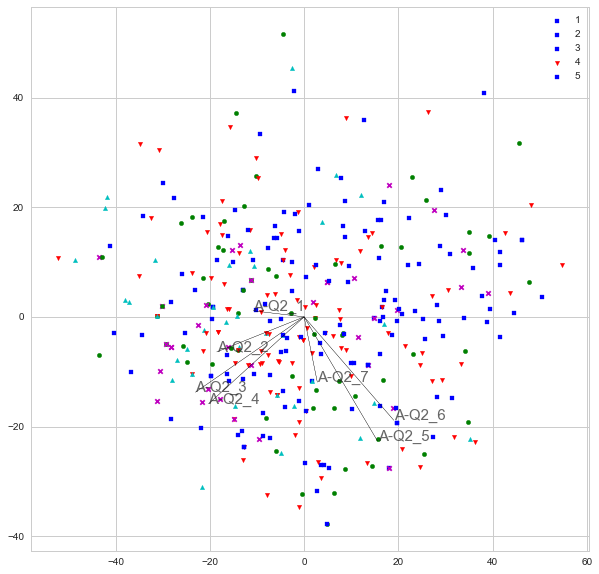

In [100]:
graf_biplot(Finished[Finished['D-Q4_neu']!=0][Liste_A_Q2],7,Finished[Finished['D-Q4_neu']!=0]['D-Q4_neu'])

n(1)= 287
n(2)= 91
n(3)= 6


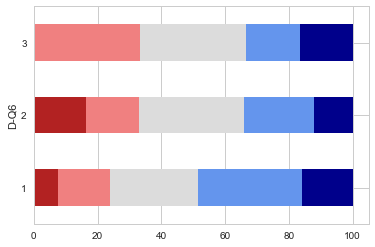

In [101]:
graf_diff_likert(Finished,'A-Q2_6','D-Q6');

In [102]:
df_test(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.718766,0.0580095,0.137,0.524765,0.15836
A-Q3_2,0.687633,0.108307,0.167948,0.379556,0.127954
A-Q3_3,0.0461003,0.48443,0.20516,0.63598,0.41581
A-Q3_4,0.511128,0.428897,0.0238946,0.840159,0.0159038
A-Q3_5,0.317178,0.00710896,0.050103,0.991811,0.27319
A-Q3_6,0.512935,0.00222531,8.92328e-08,0.00508136,0.286744
A-Q3_7,0.468818,0.000200322,2.81962e-10,0.00195816,0.251741
A-Q3_8,0.0824661,2.07128e-05,9.34152e-11,6.69927e-05,0.338006
A-Q3_9,0.0702715,0.000360269,0.0011927,0.172705,0.192495
A-Q3_28,0.599182,0.124317,0.15363,0.35537,0.440627


In [103]:
df_spearman(Finished,Liste_A_Q3)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
A-Q3_1,0.0257575,0.0178851,-0.0324192,0.0137284,0.0643286
A-Q3_2,-0.0356895,-0.0397815,-0.0842275,-0.0344582,0.0729916
A-Q3_3,-0.149657,0.0275669,-0.0994902,-0.00949256,0.00660861
A-Q3_4,0.0682142,-0.0478814,-0.0920461,-0.0152196,-0.0628978
A-Q3_5,-0.0490709,0.000757714,0.0164324,0.00964436,0.0222548
A-Q3_6,0.00673765,0.212981,0.294848,0.192775,0.0238553
A-Q3_7,0.0758419,0.252658,0.348607,0.205826,-0.00816626
A-Q3_8,-0.0339574,0.265996,0.338161,0.202955,0.029439
A-Q3_9,-0.110896,0.185917,0.172971,0.0728299,-0.0455453
A-Q3_28,0.0192339,0.0642016,0.104529,0.0911894,-0.0169906


Ergebnisse im Bereich "A-Q3":

Der Großteil der erkennbaren Unterschiede zwischen Gruppen in Bezug auf das Antwortverhalten bei einzelnen Items ist bei den Variablen Studienjahr, Niveau des aktuellen Deutschkurses und Alter zu finden. Die am stärksten beeinflussten Items sind 6, 7 und 8 (Analyse von Wortteilen, wobei sowohl grammatikalische als auch lexikalische Vorkenntnisse genutzt werden), diese korrelieren positiv mit den genannten Variablen, insbesondere dem Niveau. Weniger stark, aber ähnlich ist der Effekt bei Item 9 (orthographische Kenntnisse nutzen). Item 5 (Lautentsprechungen mit anderen germanischen Sprachen nutzen) wird vor allem von TN des vierten Studienjahres angegeben, allerdings auch stärker von TN des ersten Jahres als des zweiten und dritten. (Das könnte daran liegen, dass Studierende anderer Philologien (darunter Anglistik) Deutsch meist im ersten, zum Teil auch noch im zweiten Studienjahr belegen - und nur diese an der Befragung teilnahmen.) Item 10 (Satzstellung) scheint am stärksten von TN in Niveau A2 gewählt zu werden, allerdings auch verstärkt im vierten Studienjahr und in weiterführenden Studien, Item 11 und 12 (syntaktische und semantische Relationen) leicht zunehmend mit Niveau, am stärksten auf B2, ebenso verstärkt in weiterführenden Studien. Letzteres trifft auch auf Item 13 (systematische lexikalische Beziehungen) zu. Item 14 (Konnektoren etc.) wird vor allem auf den mittleren Niveaus angegeben, Item 16 mit leicht zunehmender Tendenz nach Niveau (in etwas in Korrelation mit Studienjahr und Alter).

Die Variable Studienrichtung scheint bei Item 3 (Vergleich mit anderen Sprachen), Item 24 (Kommunikationssituation etc.) und Item 29 (weiteren Kontext zur Kontrolle nutzen) zu unterschiedlichem Antwortverhalten zu führen. Item 3 wird verstärkt von Germanistikstudierenden, gefolgt von anderen Philologien und Translation, angegeben, Item 24 wird von Studierenden anderer Studienrichtungen weniger häufig genutzt, Item 29 von Studierenden anderer Philologien.

Die Unterschiede in Bezug auf die Variable Geschlecht stellen sich bei näherer Betrachtung als wenig aussagekräftig heraus. Weibliche TN geben Item 15 (Erkärungshilfen im Text nutzen), ebenso Item 4 (Klang) und 16 (logische Zusammenhänge). Bei Item 19 (Fachwissen) und 20 (Weltwissen) ist es umgekehrt (mehr Zuspruch unter männlichen TN).


Im Bereich "A-Q4" (kombinierte Strategiennutzung) konnten keine Unterschiede festgestellt werden.

n(1)= 146
n(2)= 60
n(3)= 103
n(4)= 34
n(5)= 35


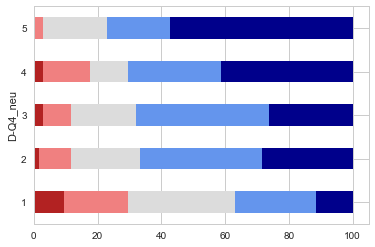

In [104]:
graf_diff_likert(Finished,'A-Q3_7','D-Q4_neu');

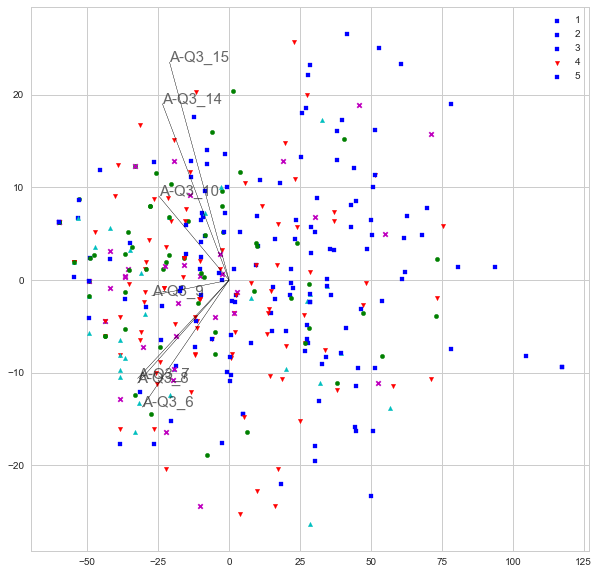

In [105]:
graf_biplot(Finished[Finished['D-Q4_neu']!=0][fakt['F1']],7,Finished[Finished['D-Q4_neu']!=0]['D-Q4_neu'])

In [106]:
df_test(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.289751,0.0284815,0.032553,0.013105,0.336042
C-Q1_2,0.710204,0.44379,0.0288777,0.548266,0.353475
C-Q1_3,0.420247,0.121296,0.0150643,0.704054,0.0544477
C-Q1_4,0.124659,0.299893,0.0181235,8.9333e-05,0.444205
C-Q1_5,0.298107,0.0371328,0.326933,0.0158317,0.409249
C-Q1_6,0.412963,0.813215,0.986074,0.025572,0.116397
C-Q1_7,0.371045,0.182882,0.651416,0.0193106,0.188986


In [107]:
df_spearman(Finished,Liste_C_Q1)

,Studium,Studienjahr,Niveau_Deutschkurs,Alter,Geschlecht
C-Q1_1,0.0312548,0.0826082,0.133303,0.0645753,-0.046856
C-Q1_2,0.0144301,-0.0598871,-0.155006,0.0424787,0.0472148
C-Q1_3,-0.0344238,0.127986,0.169897,0.0515854,0.0821218
C-Q1_4,0.0529244,0.104396,0.15172,0.166927,0.0361898
C-Q1_5,-0.00453121,0.147396,0.0934733,0.126552,0.0505437
C-Q1_6,-0.0624782,0.0667258,0.0326192,0.166735,0.0789863
C-Q1_7,0.0363584,-0.0985123,-0.0702101,-0.146623,-0.0579939


Ergebnisse im Bereich "C-Q1":

Bis auf eine Ausnahme fallen die Ergebnisse der Unterschiedshypothesen- und Korrelationstests weniger deutlich als in anderen Bereichen der Befragung aus.

Es scheint ein Zusammenhang zwischen der Bedeutung, der Erschließungsstrategien bzw. deren Erwerb zugesprochen wird (Items 4, 5 und 6 bzw. Item 7 mit negativem Vorzeichen), und dem Alter der Befragten zu bestehen. (Je älter, desto bewusster.) 

Eine leicht positive Korrelation besteht zwischen Item 1 (wahrgenommene Strategienkompetenz), Item 3 (Einsatz der Strategien in der Freizeit) und dem Niveau des aktuellen Deutschenkurses, eine leicht negative zu Item 2 (Bedeutung der Strategien im aktuellen Deutschkurs).

n(1)= 146
n(2)= 60
n(3)= 103
n(4)= 34
n(5)= 35


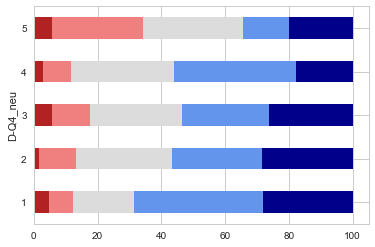

In [108]:
graf_diff_likert(Finished,'C-Q1_2','D-Q4_neu');

##### Sprachkenntnisse

In [109]:
df_test2(Finished,Liste_A_Q2)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q2_1,0.175402,0.190228,0.0963055,0.208085,0.43507,0.105034,0.0957262,0.413845,0.475264
A-Q2_2,0.241634,0.46089,0.242011,0.334106,0.440307,0.00732996,0.105179,0.10621,0.316994
A-Q2_3,0.261618,0.325804,0.18347,0.167178,0.280041,0.00249991,0.00509267,0.117962,0.34653
A-Q2_4,0.111564,0.459077,0.309011,0.348082,0.129806,0.000138317,0.0329131,0.15408,0.484624
A-Q2_5,0.336,0.393787,0.0091305,0.179259,0.0355658,0.269703,0.323969,0.219267,0.0782595
A-Q2_6,0.0925329,0.37136,0.00911673,0.185454,0.0291609,0.200478,0.138551,0.00705916,0.430327
A-Q2_7,0.283139,0.295197,0.268505,0.210965,0.258598,0.283978,0.0489764,0.454109,0.474152


Unterschiede im Antwortverhalten lassen sich in folgenden Bereichen feststellen:

* TN mit Kenntnis weiterer germanischer Sprachen: häufiger Nutzung weiterer Sprachkenntnisse, Kenntnisse des Deutschen und Kontext
* TN mit Kenntnis weiterer romanischer Sprachen: häufiger Nutzung der Kenntnisse des Deutschen und Kontext, außerdem etwas weniger Zuspruch bei Wörterbuchnutzung
* TN mit Französischkenntnissen, ähnlich auch bei Latein: mehr soziale Strategien 
* TN mit Kenntnis slawischer Sprachen: weniger soziale Strategien, vor allem Item 6 (Hilfe durch Kommilitonen) 


n(0)= 358
n(1)= 32


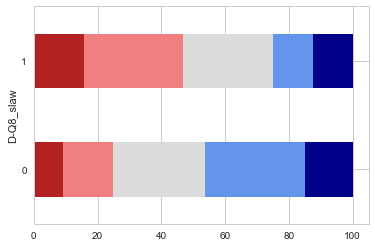

In [110]:
graf_diff_likert2(Finished,'A-Q2_6','D-Q8_slaw');

In [111]:
df_test2(Finished,Liste_A_Q3)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
A-Q3_1,0.00872596,0.247371,0.106896,0.272676,0.476217,0.0612518,0.00872431,0.436799,0.377797
A-Q3_2,0.363789,0.0599035,0.272408,0.253684,0.311026,0.0795338,0.349366,0.466178,0.105728
A-Q3_3,0.131539,0.225585,0.0412368,0.0887467,0.408421,0.00191444,0.185473,0.0389049,0.0630173
A-Q3_4,0.020044,0.342023,0.00992478,0.367274,0.357163,0.233246,0.406361,0.229507,0.116131
A-Q3_5,0.11881,0.154361,0.439207,0.122936,0.375043,0.0231618,0.0193208,0.187996,0.0239429
A-Q3_6,0.338064,0.491084,0.172421,0.231927,0.283662,0.0148944,0.243079,0.0706147,0.126849
A-Q3_7,0.472651,0.168468,0.348892,0.0708275,0.0496516,0.00732952,0.0839307,0.0317587,0.124092
A-Q3_8,0.160736,0.102709,0.468997,0.0124888,0.00973692,0.000547896,0.397231,0.251842,0.259938
A-Q3_9,0.00323042,0.0325399,0.392237,0.146233,0.109414,0.00087404,0.124746,0.0464295,0.377362
A-Q3_28,0.0581359,0.0989248,0.108149,0.102716,0.233834,0.0250183,0.138557,0.0149333,0.445073


n(0)= 353
n(1)= 37


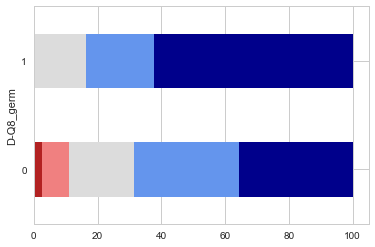

In [112]:
graf_diff_likert2(Finished,'A-Q3_9','D-Q8_germ');

Ergebnisse im Bereich "A-Q3":

* TN mit Spanisch als (einer der) Erstsprache(n): häufiger Nutzung der Erstsprache, auch andere Strategien wie Orthographie, Symbole... 
* Bilinguale TN: wenig signifikante Unterschiede, weniger Nutzung von Hyperlinks, andere Items etwas mehr
* TN mit Franz.: mehr Nutzung anderer Sprachkenntnisse und Klang
* TN mit Latein: Item 7 und 8 verstärkt (morphologisches Wissen und Kenntnis der Bedeutung von Suffixen etc.); ähnlich bei Altgr.: Item 8, auch 14
* TN mit germ. K.: bei vielen Items größerer Zuspruch, stärkste Unterschiede bei 7, 8 und 9
* TN mit rom. K.: stärkere Nutzung der Erstsprache, verstärkt auch einige andere Items, darunter Weltwissen, Strategienkombination
* TN mit slaw. K.: häufiger Item 15 (Erklärungshilfen) und 16 (logische Zusammehänge), auch einige weitere
* TN mit asiat. K.: häufiger Item 31 (weitere Strategien bei Problemen suchen), bei Item 5 extremeres Antwortverhalten (wenig "3")


In Bezug auf Muster in der Strategiennutzung (A-Q4) zeigt sich ein positiver Zusammenhang mit Altgriechischkenntnissen, ebenso Latein, in geringerem Maße auch germanischen und slawischen Sprachen.

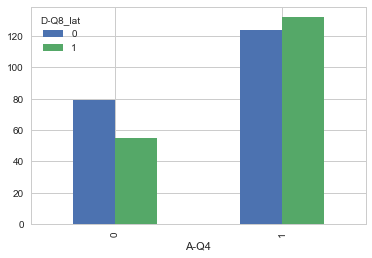

In [113]:
graf_diff2(Finished,'A-Q4','D-Q8_lat');

In [114]:
df_test2(Finished,Liste_C_Q1)

,Erstspr_Sp,Erstspr_bi,Franz,Altgriech,Latein,Germ,Rom,Slaw,Asiat
C-Q1_1,0.368478,0.320908,0.16448,0.463221,0.143519,0.00655009,0.0453963,0.0411635,0.212051
C-Q1_2,0.0785706,0.246138,0.179813,0.107519,0.243505,0.225683,0.0140895,0.410978,0.116875
C-Q1_3,0.0412318,0.372839,0.275128,0.216334,0.408781,5.8185e-06,0.110563,0.000115082,0.00806101
C-Q1_4,0.153809,0.293681,0.191012,0.0497555,0.121394,0.108021,0.060169,0.243941,0.494557
C-Q1_5,0.388287,0.182565,0.439795,0.238779,0.254283,0.0155671,0.0106723,0.117119,0.381101
C-Q1_6,0.131295,0.215642,0.330492,0.260155,0.0266685,0.00152597,0.335054,0.465446,0.03308
C-Q1_7,0.396486,0.27346,0.109332,0.487654,0.493327,0.434874,0.314149,0.443166,0.319621


Erkenntnisse im Bereich C-Q1:

* TN mit germ. K.: stärkere Zustimmung zu Bedeutung von Erschließungsstrategien und deren Training, eigene Kompetenz und Nutzung in der Freizeit
* TN mit slaw., asiat. K.: häufigere Nutzung in der Freizeit (ev. auf Erschließung anderer Sprachen bezogen?)

Die weiteren Unterschiede können als kaum signifikant betrachtet werden.

n(0)= 353
n(1)= 37


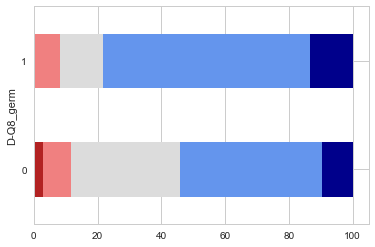

In [115]:
graf_diff_likert2(Finished,'C-Q1_1','D-Q8_germ');

##### Strategienerwerbskontexte

In [116]:
df_test3(Finished,Liste_A_Q2)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q2_1,0.49378,0.444053,0.283473,0.399399,0.0258077,0.358996,0.483507,0.173157,0.209704
A-Q2_2,0.374349,0.356219,0.140799,0.291892,0.0821503,0.158093,0.027317,0.257878,0.00280428
A-Q2_3,0.482022,0.29223,0.00793167,4.39746e-05,3.76462e-06,0.042728,0.180891,0.00523911,0.0202842
A-Q2_4,0.0935396,0.318228,0.276689,0.000150556,0.00275364,0.0501087,0.00204329,0.00476239,0.0319838
A-Q2_5,0.00517345,0.00500057,0.0467035,0.184772,0.383895,0.0343721,0.00608435,0.37432,0.203177
A-Q2_6,0.19595,0.000603458,0.0155172,0.00337626,0.237401,0.188267,0.075076,0.305911,0.00912113
A-Q2_7,0.28599,0.442332,0.05242,0.0481501,0.316062,0.0217097,0.0129721,0.238647,0.486091


In [117]:
df_test3(Finished,Liste_A_Q3)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
A-Q3_1,0.430694,0.0762605,0.0301392,0.166078,0.283826,0.211762,0.0646173,0.261398,0.181119
A-Q3_2,0.304775,0.00920999,0.0523262,0.0380489,0.33652,0.406696,0.384596,0.0940453,0.118636
A-Q3_3,0.493677,0.0922206,0.00296696,0.142066,0.32068,0.241283,0.238884,0.459496,0.0351946
A-Q3_4,0.470563,0.139599,0.210369,0.133151,0.315,0.159598,0.275518,0.0345711,0.427905
A-Q3_5,0.128154,0.381043,0.0195554,0.401571,0.0530219,0.318169,0.492868,0.152693,0.298488
A-Q3_6,0.00644985,0.306507,0.0412867,0.00128789,0.0013961,0.0902024,0.265012,0.00863803,0.0608667
A-Q3_7,0.189561,0.119728,0.0570996,2.3944e-05,2.07588e-05,0.207972,0.184271,0.0462629,0.0950379
A-Q3_8,0.0548808,0.0244408,0.368759,8.92455e-05,4.9796e-06,0.185143,0.23922,0.0511423,0.00178513
A-Q3_9,0.246445,0.414741,0.463682,0.000138747,0.000166631,0.0589254,0.032746,0.0283595,0.00134012
A-Q3_28,0.125461,0.156901,0.140691,0.013475,0.0272367,0.179904,0.0371542,0.00217762,0.130456


In [148]:
get_good_str(Finished[Finished['B-Q2_E1']==1])

(91, 65.46762589928058)

In [149]:
get_good_str(Finished[Finished['B-Q2_E2']==1])

(156, 70.9090909090909)

In [150]:
get_good_str(Finished[Finished['B-Q2_E3']==1])

(122, 69.31818181818183)

In [151]:
get_good_str(Finished[Finished['B-Q2_E4']==1])

(84, 70.58823529411765)

In [152]:
get_good_str(Finished[Finished['B-Q2_E5']==1])

(104, 76.47058823529412)

In [153]:
get_good_str(Finished[Finished['B-Q2_E6']==1])

(115, 73.24840764331209)

In [154]:
get_good_str(Finished[Finished['B-Q2_E7']==1])

(159, 68.53448275862068)

In [155]:
get_good_str(Finished[Finished['B-Q2_E8']==1])

(67, 73.62637362637363)

In [156]:
get_good_str(Finished[Finished['B-Q2_E9']==1])

(147, 67.12328767123287)

In [118]:
df_test3(Finished,Liste_C_Q1)

,E1,E2,E3,E4,E5,E6,E7,E8,E9
C-Q1_1,0.023853,0.193494,0.159266,0.338905,0.00615263,0.455685,0.156928,0.0183788,0.00453191
C-Q1_2,0.0320839,0.0259582,0.013764,0.144959,0.0463571,0.419601,0.00897872,0.403365,0.224211
C-Q1_3,0.0183371,0.0963517,0.212522,0.0485834,0.00585558,0.257579,0.0763913,0.0538626,0.0076986
C-Q1_4,0.346671,0.305555,0.432337,0.0059743,0.0259004,0.201647,0.00517378,0.0788012,0.0541259
C-Q1_5,0.393336,0.165803,0.270206,0.126279,0.000437044,0.293179,0.0272636,0.195059,0.0466985
C-Q1_6,0.218827,0.360078,0.275213,0.104851,2.55576e-05,0.240573,0.0287954,0.150345,0.492701
C-Q1_7,0.188723,0.232464,0.0431042,0.218171,0.164495,0.123763,0.00236505,0.0426596,0.365479


##### Methoden des Strategienerwerbs in Unterrichtskontexten

In [119]:
df_test4(Finished,Liste_A_Q2)

,U1,U2,U3,U4,U5,U6
A-Q2_1,0.209211,0.0598179,0.0923377,0.300915,0.360079,0.291934
A-Q2_2,0.173046,0.343757,0.172517,0.0650371,0.0108366,0.0230903
A-Q2_3,0.150018,0.0369125,0.0441735,0.00274545,0.000631001,0.020431
A-Q2_4,0.258065,0.455679,0.0486804,0.0274783,0.325265,0.000538525
A-Q2_5,0.061453,0.163256,0.0138595,0.394778,0.0896321,0.356745
A-Q2_6,0.303697,0.0348541,0.0382399,0.312703,0.172759,0.499409
A-Q2_7,0.330794,0.0504621,0.0231831,0.481144,0.182686,0.192923


In [120]:
df_test4(Finished,Liste_A_Q3)

,U1,U2,U3,U4,U5,U6
A-Q3_1,0.39716,0.283206,0.403982,0.302912,0.163727,0.00311441
A-Q3_2,0.431834,0.111725,0.0458044,0.27304,0.152965,0.00197753
A-Q3_3,0.263703,0.107811,0.12942,0.0313569,0.00172316,0.0430252
A-Q3_4,0.365705,0.254119,0.147452,0.0637012,0.269884,0.280231
A-Q3_5,0.302696,0.0263312,0.239125,0.0122395,0.401528,0.146346
A-Q3_6,0.455892,0.259122,0.455349,0.0951489,0.359714,0.0998038
A-Q3_7,0.484804,0.36052,0.270054,0.0377218,0.48454,0.0320985
A-Q3_8,0.174408,0.128437,0.49833,0.240016,0.44548,0.0179702
A-Q3_9,0.384175,0.220573,0.301581,0.30498,0.0481805,0.190711
A-Q3_28,0.150974,0.261216,0.026503,0.106271,0.495761,0.46135


In [142]:
get_good_str(Finished[Finished['B-Q2_U1']==1])

(143, 71.14427860696517)

In [143]:
get_good_str(Finished[Finished['B-Q2_U2']==1])

(173, 70.04048582995951)

In [144]:
get_good_str(Finished[Finished['B-Q2_U3']==1])

(142, 71.71717171717171)

In [145]:
get_good_str(Finished[Finished['B-Q2_U4']==1])

(88, 77.19298245614034)

In [146]:
get_good_str(Finished[Finished['B-Q2_U5']==1])

(113, 76.35135135135135)

In [147]:
get_good_str(Finished[Finished['B-Q2_U6']==1])

(177, 67.30038022813687)

In [121]:
df_test4(Finished,Liste_C_Q1)

,U1,U2,U3,U4,U5,U6
C-Q1_1,0.412408,0.28744,0.0388713,0.37098,0.127796,0.00770602
C-Q1_2,0.0537277,7.11644e-05,0.00137414,0.00800309,0.00347189,0.151402
C-Q1_3,0.108755,0.299947,0.126993,0.335831,0.288071,0.0078081
C-Q1_4,0.0508477,0.270783,0.112996,0.279649,0.00486872,0.0148164
C-Q1_5,0.0009061,0.026338,0.0244708,0.082721,0.0818027,0.00394622
C-Q1_6,0.00835608,0.00578504,0.0015506,0.481713,0.0442835,0.0862857
C-Q1_7,0.0489648,0.0182589,0.0112128,0.319702,0.0127889,0.178039


##### Studium

In [122]:
graf_diff_likert(Finished,'A-Q3_3','D-Q2a_neu',1,2,3,4)

TypeError: graf_diff_likert() takes 3 positional arguments but 7 were given

In [ ]:
graf_diff_likert(Daten,'A-Q3_29','D-Q2a_neu',1,2,3,4)

In [ ]:
graf_diff_likert(Daten,'A-Q3_24','D-Q2a_neu',1,2,3,4)

##### Studienjahr

##### Niveau des aktuellen Deutschkurses

In [ ]:
graf_diff_likert(Daten,'A-Q2_2','D-Q4',1,2,3,4,5)

In [ ]:
graf_diff(Daten,'A-Q2_2','D-Q4_neu')

##### Sprachkenntnisse

Erstsprachen:

Weitere Sprachkenntnisse:

##### Alter

##### Geschlecht

##### Strategienerwerbskontexte

##### Erhebungssituation

In [ ]:
df_test5(Finished,Liste_A_Q2)

In [ ]:
df_test5(Finished,Liste_A_Q3)

In [ ]:
df_test5(Finished,Liste_C_Q1)

Nur bei wenigen Items kann ein Einfluss der Erhebungssituation vermutet werden. Die Ergebnisse sind nicht eindeutig, zudem kann der Einfluss auch durch die Erhebung an unterschiedlichen Universitäten zustandekommen. 

Eine weitere besondere Erhebungssituation stellt die Durchführung der Befragung mittels der Papierversion des Fragebogens dar. Die größte Gruppe von Studierenden, die mittels Papierfragebogen befragt wurden, stellt jene der Universität Sevilla (n=56) dar. Im Vergleich der Gruppe aus Sevilla mit den Studierenden anderer Universitäten zeigen sich tatsächlich einige Unterschiede im Antwortverhalten. 

Ein ähnliches Bild zeigt sich jedoch auch, wenn die Analyse mit anderen Universitäten (z.B. Vigo oder Salamanca) durchgeführt wird. 

Ein Einfluss der Verwendung des Papierfragebogens auf das Antwortverhalten kann daher nicht mit Sicherheit festgestellt werden. 

Die Analyse zeigt, dass ein Zusammenhang zwischen bestimmten Items und der Zugehörigkeit der Befragten zu unterschiedlichen Universitäten vorliegt. Allerdings sind mit der Universitätszugehörigkeit auch andere Faktoren wie Studienrichtung und Niveau des besuchten Deutschkurses sowie die Lehrkraft (nicht als Faktor erhoben, aber in der Fachliteratur angenommen) verbunden, sodass keine aussagekräftigen Schlüsse gezogen werden können. 

In [ ]:
df_test5(Daten[Daten['Finished']==1],Liste_D[1:])

##### Pilotstudie

In der Folge wird untersucht, ob sich das Antwortverhalten der TN an der Pilotstudie und der Hauptstudie an der Universität Salamanca unterscheidet.

In [ ]:
Finished[Finished['D-Q1']==63]['pilot'].value_counts()

Tatsächlich gibt es Hinweise auf unterschiedliches Antwortverhalten. Dieses kann jedoch durch andere Variablen, die ebenfalls beide Stichproben unterscheiden, zustandegekommen sein.

Als zusätzlicher Test wurden die zuvor dargestellten Analysen auch unter Ausschluss der Teilnehmer der Pilotstudie durchgeführt. Die Ergebnisse unterscheiden sich nicht wesentlich, zum Teil wären weniger Unterschiede zwischen Gruppen (z.B. Studienrichtungen) erkenntlich. Dies lässt vermuten, dass die unterschiedliche Zusammensetzung der Stichprobe mehr Einfluss auf das Antwortverhalten hat als die Verwendung eines geringfügig anders gestalteten Fragebogens. (Die sprachlich abgeänderten Items 12 und 14 zeigen kein verändertes Antwortverhalten.)

### Biplot?

In [ ]:
def graf_cplot(data, dim, nclust, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    ward = AgglomerativeClustering(n_clusters=nclust).fit(data)
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)

    sh_v = vector_to_shape(ward.labels_)
    color_v = vector_to_color(ward.labels_)

    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i] , marker = sh_v[i]);

In [ ]:
Finished['D-Q2'][87]

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2a'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2b'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q3'])

In [ ]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q4'])

In [ ]:
graf_cplot(Daten[Liste_A_Q2],7,6)

In [ ]:
graf_cplot(Daten[Liste_A_Q2],7,6,dim1=0,dim2=2)

Ergebnisse der Faktorenanalyse (mit R durchgeführt)